In [1]:
import os
import glob
import numpy as np
import librosa
import librosa.display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchsummary import summary


import soundfile as sf

In [2]:
class AudioDataset(Dataset):
    def __init__(self, path, transform=None, sample_rate=16000):
        self.path = path
        self.data_list = glob.glob(self.path + '/*.wav')
        
        self.transform = transform
        self.sr = sample_rate
        self.frame_length = 0.025
        self.frame_stride = 0.0126

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data_path = self.data_list[idx]
        data = self.log_Mel_S(data_path)
        data = np.expand_dims(data, axis=0)

        if self.transform is not None:
            data = self.transform(data)
        return data # (1, 40, 80)
    
    def log_Mel_S(self, wav_file):
        y, sr = librosa.load(wav_file, sr=self.sr)
        if len(y) < 16000:
            y = np.pad(y, (0,16000 - len(y)))
        elif len(y) > 16000:
            y = y[:16000]
        else:
            y = y

        input_nfft = int(round(sr * self.frame_length))
        input_stride = int(round(sr * self.frame_stride))

        s = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
        s = librosa.power_to_db(s, ref=np.max)
        return s

In [3]:
dataset = AudioDataset(path='/mnt/storage1/위급상황 음성_음향/Training/low_16_1s')

print(f'dataset.__len__() : {dataset.__len__()}')
dataset_indices = list(range(dataset.__len__()))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset.__len__()))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset=dataset, batch_size=100, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(dataset=dataset, batch_size=100, sampler=val_sampler, shuffle=False)

dataset.__len__() : 23863


In [4]:
class AE(nn.Module):
    def __init__(self, input_channel=1):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channel, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

    def get_codes(self, x):
        return self.encoder(x)

In [5]:
ae = AE()
if torch.cuda.is_available():
    ae.cuda()

In [6]:
ae

AE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [7]:
summary(ae, (1, 40, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 40, 80]             320
       BatchNorm2d-2           [-1, 32, 40, 80]              64
              ReLU-3           [-1, 32, 40, 80]               0
         MaxPool2d-4           [-1, 32, 20, 40]               0
            Conv2d-5           [-1, 64, 20, 40]          18,496
       BatchNorm2d-6           [-1, 64, 20, 40]             128
              ReLU-7           [-1, 64, 20, 40]               0
         MaxPool2d-8           [-1, 64, 10, 20]               0
            Conv2d-9          [-1, 128, 10, 20]          73,856
      BatchNorm2d-10          [-1, 128, 10, 20]             256
             ReLU-11          [-1, 128, 10, 20]               0
        MaxPool2d-12           [-1, 128, 5, 10]               0
  ConvTranspose2d-13           [-1, 64, 10, 20]         131,136
      BatchNorm2d-14           [-1, 64,

In [8]:
def train(model, loss, optimizer, num_epochs, start_epoch=0, early_stopping=False):
    train_loss_arr = []
    test_loss_arr = []
    
    best_test_loss = 999999
    early_stop, early_stop_max = 0, 3

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0.
        for batch_idx, data in enumerate(train_loader):
            data = data.cuda()
            optimizer.zero_grad()

            model.train()
            outputs = model(data)
            train_loss = loss(outputs, data)
            epoch_loss += train_loss.item()

            train_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f'Epoch : {epoch + 1} [{batch_idx * len(data)}/{len(train_idx)}({100 * 100. * batch_idx/len(train_idx) :.2f}%)]'\
                    +f'\tLoss : {train_loss.item() / len(data) :.4f}')
        
        train_loss_arr.append((epoch_loss / len(train_idx)))

        # validation

        model.eval()
        test_loss = 0.
        for data in val_loader:
            data = data.cuda()

            outputs = model(data)
            batch_loss = loss(outputs, data)
            test_loss += batch_loss.item()

        test_loss_arr.append((test_loss / len(val_idx)))

        if early_stopping:
            if best_test_loss > test_loss:
                best_test_loss = test_loss
                early_stop = 0
                print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch-start_epoch] :.4f}, ' +\
                f'Average Test Loss : {test_loss_arr[epoch-start_epoch] :.4f}\n')
            else:
                early_stop += 1
                print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch-start_epoch] :.4f}, ' +\
                f'Average Test Loss : {test_loss_arr[epoch-start_epoch] :.4f}\n')

            if early_stop >= early_stop_max:
                break
        else:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Average Train Loss : {train_loss_arr[epoch-start_epoch] :.4f}, ' +\
            f'Average Test Loss : {test_loss_arr[epoch-start_epoch] :.4f}\n')
    return train_loss_arr, test_loss_arr

In [9]:
ae_loss = nn.MSELoss()
ae_optimizer = optim.Adam(ae.parameters())
avg_train_loss, avg_test_loss = train(ae, ae_loss, ae_optimizer, 50, start_epoch=0, early_stopping=True)

Epoch : 1 [0/19091(0.00%)]	Loss : 8.2917
Epoch : 1 [1000/19091(5.24%)]	Loss : 7.5113
Epoch : 1 [2000/19091(10.48%)]	Loss : 7.6436
Epoch : 1 [3000/19091(15.71%)]	Loss : 7.1449
Epoch : 1 [4000/19091(20.95%)]	Loss : 7.7339
Epoch : 1 [5000/19091(26.19%)]	Loss : 6.5930
Epoch : 1 [6000/19091(31.43%)]	Loss : 6.0526
Epoch : 1 [7000/19091(36.67%)]	Loss : 5.4553
Epoch : 1 [8000/19091(41.90%)]	Loss : 5.4486
Epoch : 1 [9000/19091(47.14%)]	Loss : 5.0632
Epoch : 1 [10000/19091(52.38%)]	Loss : 4.9704
Epoch : 1 [11000/19091(57.62%)]	Loss : 4.3087
Epoch : 1 [12000/19091(62.86%)]	Loss : 3.9559
Epoch : 1 [13000/19091(68.09%)]	Loss : 3.2372
Epoch : 1 [14000/19091(73.33%)]	Loss : 3.4271
Epoch : 1 [15000/19091(78.57%)]	Loss : 2.7346
Epoch : 1 [16000/19091(83.81%)]	Loss : 2.4093
Epoch : 1 [17000/19091(89.05%)]	Loss : 2.2729
Epoch : 1 [18000/19091(94.29%)]	Loss : 2.0207
Epoch : 1 [17290/19091(99.52%)]	Loss : 1.8041
Epoch [1/50], Average Train Loss : 4.8896, Average Test Loss : 1.6880

Epoch : 2 [0/19091(0.00%

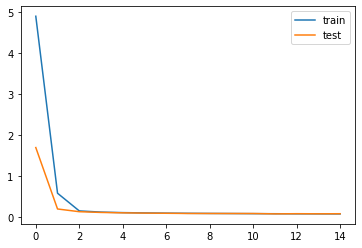

In [10]:
import matplotlib.pyplot as plt
plt.plot(avg_train_loss, label='train')
plt.plot(avg_test_loss, label='test')
plt.legend()

plt.show()

In [11]:
def plot_mel(s):
    sr = 16000
    frame_stride = 0.0126
    input_stride = int(round(sr*frame_stride))
    librosa.display.specshow(s, sr=16000, hop_length=input_stride,\
        y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectogram')
    plt.tight_layout()
    plt.show()

In [12]:
def plot_mel_2(s1, s2):
    sr = 16000
    frame_stride = 0.0126
    input_stride = int(round(sr*frame_stride))

    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    librosa.display.specshow(s1, sr=16000, hop_length=input_stride,\
        y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Original')
    plt.tight_layout()

    plt.subplot(1,2,2)
    librosa.display.specshow(s2, sr=16000, hop_length=input_stride,\
        y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Output')
    plt.tight_layout()

    plt.show()

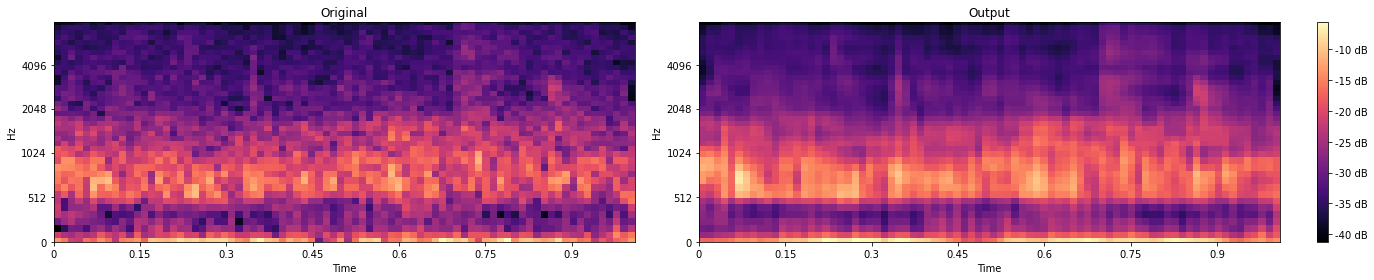

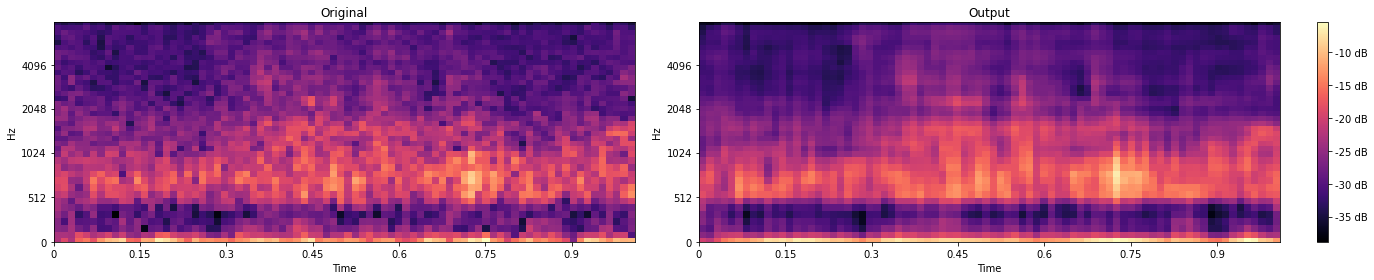

In [13]:
for data in train_loader:
    for i in range(2):
        a = data[i].cpu().detach().numpy()
        b = ae(torch.Tensor(a.reshape(1,1,40,80)).cuda())
        plot_mel_2(a.squeeze(), b.cpu().detach().numpy().squeeze())
    break

In [14]:
def log_Mel_S(wav_file):
    sr = 16000
    frame_length = 0.025
    frame_stride = 0.0126 
    y, sr = librosa.load(wav_file, sr=sr)
    if len(y) < 16000:
        y = np.pad(y, (0,16000 - len(y)))
    elif len(y) > 16000:
        y = y[:16000]
    else:
        y = y

    input_nfft = int(round(sr * frame_length))
    input_stride = int(round(sr * frame_stride))

    s = librosa.feature.melspectrogram(y=y, n_mels=40, n_fft=input_nfft, hop_length=input_stride)
    s = librosa.power_to_db(s, ref=np.max)
    return s

def log_mel_to_audio(log_mel):
    sr = 16000
    frame_length = 0.025
    frame_stride = 0.0126 
    
    mel = librosa.db_to_power(log_mel)
    
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    return librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=input_nfft, hop_length=input_stride)

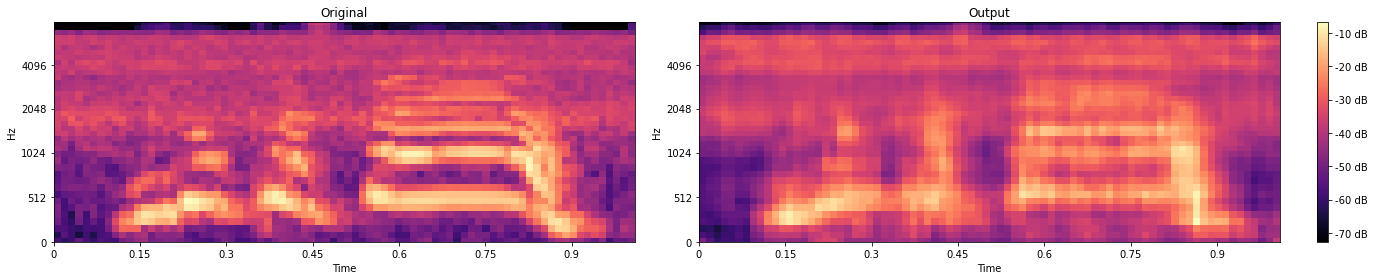

loss : 56.969764709472656


In [15]:
mse = nn.MSELoss()
data_path = 'data/원천데이터/abnormal_1s/가스사고_512992_label_1.wav'
s = log_Mel_S(data_path)
out = ae(torch.Tensor(s.reshape(1,1,40,80)).cuda())
out = out.cpu().detach().numpy().squeeze()
plot_mel_2(s, out)

loss = mse(torch.Tensor(s).cuda(), torch.Tensor(out).cuda())
print(f"loss : {loss}")

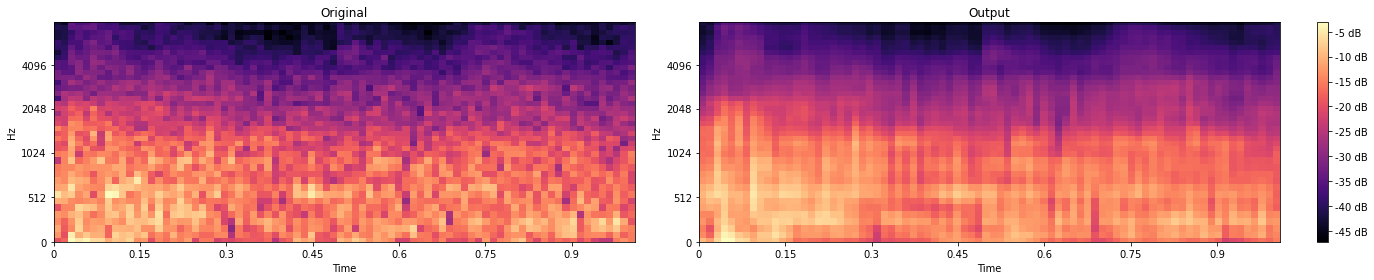

loss : 6.9940714836120605


In [16]:
data_path = 'data/원천데이터/normal_1s/실내_673584_label_0.wav'
s = log_Mel_S(data_path)
out = ae(torch.Tensor(s.reshape(1,1,40,80)).cuda())
out = out.cpu().detach().numpy().squeeze()
plot_mel_2(s, out)

loss = mse(torch.Tensor(s).cuda(), torch.Tensor(out).cuda())
print(f"loss : {loss}")

In [17]:
abnormal_dataset = AudioDataset(path='data/원천데이터/abnormal_1s')

abnormal_loader = DataLoader(dataset=abnormal_dataset, batch_size=1, shuffle=False)

In [18]:
mse = nn.MSELoss()
abnormal_loss = []

for idx, data in enumerate(abnormal_loader):
    if idx == 2800:
        break
    data = data.cuda()
    output = ae(data)
    loss = mse(data, output)
    abnormal_loss.append(loss.item())

In [19]:
len(abnormal_loss)

2800

In [20]:
val_loss = []

for idx, data in enumerate(val_loader):
    if idx == 28:
        break
    data = data.cuda()
    for d in data:
        d = d.reshape((1,1,40,80))
        output = ae(d)
        loss = mse(d, output)
        val_loss.append(loss.item())

In [21]:
len(val_loss)

2800

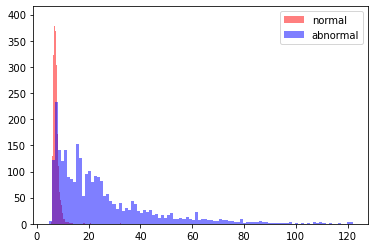

In [22]:
import matplotlib.pyplot as plt


plt.hist(val_loss, color='r', alpha=0.5, bins=100, label='normal')
plt.hist(abnormal_loss, color='b', alpha=0.5, bins=100, label='abnormal')
plt.legend()

plt.show()

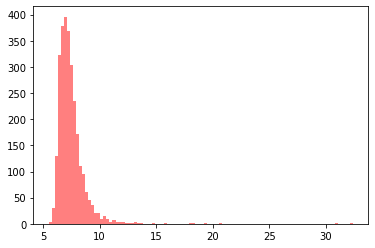

In [23]:
plt.hist(val_loss, color='r', alpha=0.5, bins=100, label='normal')
plt.show()

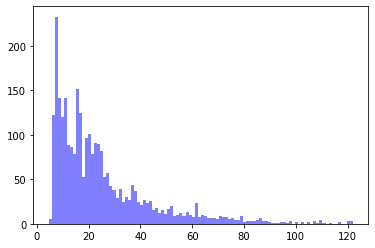

In [24]:
plt.hist(abnormal_loss, color='b', alpha=0.5, bins=100, label='abnormal')
plt.show()

In [25]:
val_loss = np.array(val_loss)
len(val_loss), sum(val_loss > 10)

(2800, 77)

In [26]:
abnormal_loss = np.array(abnormal_loss)
len(abnormal_loss), sum(abnormal_loss > 10)

(2800, 2227)

In [27]:
threshold = 10

accuracy = ( sum(val_loss <= threshold) + sum(abnormal_loss > threshold) ) / ( len(val_loss) + len(abnormal_loss) )
print(f"accuracy : {accuracy * 100}")

accuracy : 88.39285714285714


In [28]:
thres_list = np.linspace(5,15,21)
accuracy_list = []
for thres in thres_list:
    accuracy = ( sum(val_loss <= thres) + sum(abnormal_loss > thres) ) / ( len(val_loss) + len(abnormal_loss) )
    accuracy_list.append(accuracy)

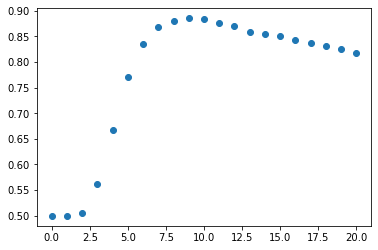

In [29]:
plt.plot(accuracy_list, 'o')
plt.show()

In [30]:
np.argmax(accuracy_list), thres_list[np.argmax(accuracy_list)], accuracy_list[np.argmax(accuracy_list)]

(9, 9.5, 0.8853571428571428)

In [33]:
thres = thres_list[np.argmax(accuracy_list)]
accuracy = ( sum(val_loss <= thres) + sum(abnormal_loss > thres) ) / ( len(val_loss) + len(abnormal_loss) )
print(f"accuracy : {accuracy * 100}")

accuracy : 88.53571428571428


In [32]:
torch.save(ae.state_dict(), 'model/model_0401.pt')

In [36]:
abnormal_loss.shape, val_loss.shape

((2800,), (2800,))

In [43]:
TN = len(abnormal_loss[abnormal_loss > thres])
FP = len(abnormal_loss[abnormal_loss <= thres])
TP = len(val_loss[val_loss <= thres])
FN = len(val_loss[val_loss > thres])

In [68]:
print(f"{' '*15}Predict{' '*15}")
print(f"{' '*13}{'Normal':10s}{'Abnormal':10s}")
print(f"Normal  {TP:10d}{FN:11d}")
print(f"Abnormal{FP:10d}{TN:11d}")

               Predict               
             Normal    Abnormal  
Normal        2680        120
Abnormal       522       2278
